# Sextortion Investigation Demo

In this demo we will investigate Bitcoin addresses that received money from Sextortion Spam victims. The data from this demo is taken from our study [Spams meet Cryptocurrencies: Sextortion in the Bitcoin Ecosystem](https://arxiv.org/abs/1908.01051) and is a subset of [all the 12,533 Bitcoin addresses](https://github.com/MatteoRomiti/Sextortion_Spam_Bitcoin) we have collected from 4,340,736 sextortion spam emails.

The data for this demo is available in `./examples/data/sextortion_addresses.json`

We are going to answer the following questions:

* Q1: How many USD did the input addresses receive in total?

* Q2: How many USD did the corresponding entities receive in total?

* Q3: How many addresses are controlled by these entities?

* Q4: Where did the money come from, where did it go to?

* Q5: Can we find any known entities (e.g., exchanges) in the digital money trace?

## Preparations

First, we install the graphsense-python package as described in the [README](https://github.com/graphsense/graphsense-python/blob/master/README.md) of this repository. Import the package and configure the API endpoint. An API key for the public GraphSense demo API can be requested by sending an email to contact@graphense.info.

In [1]:
import graphsense
from graphsense.api import addresses_api, blocks_api, entities_api, general_api, bulk_api

import json

from pprint import pprint

## Load host and API key from config


In [2]:
f = open('config.json')
config = json.load(f)
f.close()

## Configure GraphSense client


Now we configure the GraphSense Python library



In [3]:
configuration = graphsense.Configuration(
    host = config['graphsense']['host'],
    api_key = {'api_key': config['graphsense']['api_key']})

GraphSenes supports several asset types: Bitcoin (BTC), Bitcoin Cash (BCH), Litecoin (LTC), ZCash (ZEC).

We are investigating Bitcoin transactions, therefore we set the default currency to Bitcoin **BTC**.

In [4]:
CURRENCY = 'btc'

We can test whether or client works, by checking what data the GraphSense endpoint provides

In [5]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = general_api.GeneralApi(api_client)
    api_response = api_instance.get_statistics()
    pprint(api_response)

{'currencies': [{'name': 'btc',
                 'no_address_relations': 6324455334,
                 'no_addresses': 999362679,
                 'no_blocks': 744618,
                 'no_entities': 453401567,
                 'no_labels': 989,
                 'no_tagged_addresses': 235777372,
                 'no_txs': 748154188,
                 'timestamp': 1657583636},
                {'name': 'bch',
                 'no_address_relations': 2252085027,
                 'no_addresses': 331665580,
                 'no_blocks': 748221,
                 'no_entities': 150204333,
                 'no_labels': 84,
                 'no_tagged_addresses': 13369862,
                 'no_txs': 360726433,
                 'timestamp': 1657495979},
                {'name': 'ltc',
                 'no_address_relations': 1273105685,
                 'no_addresses': 140510180,
                 'no_blocks': 2273844,
                 'no_entities': 61175737,
                 'no_labels': 64,
    

Now we load the provided sample Bitcoin addresses


In [6]:
INPUT_FILE = './data/sextortion_addresses.json' # 245 sextortion addresses
with open(INPUT_FILE, 'r') as fp:
    input_addresses = json.load(fp)
    
pprint(f"Example address: {input_addresses[0]}")
print(f"Total number of addresses: {len(input_addresses)}")

'Example address: 1JwRp2J8bQcoG8XTUbxQZaEj9QB4RB6zEa'
Total number of addresses: 245


# Q1. How many USD (US dollars) did the input addresses receive in total?

In [7]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = bulk_api.BulkApi(api_client)
    # Retrieve all addresses in bulk
    addresses = api_instance.bulk_json(CURRENCY, 
                                       operation='get_address',
                                       num_pages=1,
                                       body={'address':input_addresses})

In [8]:
fiat_values = [fv['value'] 
               for el in addresses
               for fv in el['total_received']['fiat_values']
               if fv['code'] == 'usd'
               ]
total_received = sum(fiat_values)
print("{} addresses received {:,.2f} USD".format(len(addresses), total_received))

245 addresses received 886,352.11 USD


# Q2: How many USD did the corresponding entities receive in total?

For each address, fetch the corresponding entity and store it in a dict for further use

In [9]:
address_entity = dict()  # address, entity_id
entities = dict()  # entity_id, details (for later)

In [10]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = bulk_api.BulkApi(api_client)
    # Retrieve all entities in bulk
    entities_list = api_instance.bulk_json(CURRENCY, 
                                           operation='get_address_entity',
                                           num_pages=1,
                                           body={'address':input_addresses})
  
for e in entities_list:
    entities[int(e['entity'])] = e
    
print(f"They map to {len(entities)} distinct entities")

They map to 96 distinct entities


# Q3: How many addresses are controlled by these entities?

Count the number of retrieved entities, the number of addresses controlled by these entities, and sum up the total number of USD received by these entities

In [11]:
n_addresses = 0
usd_in = 0
for v in entities:
    n_addresses += entities[v]['no_addresses']
    for fv in entities[v]['total_received']['fiat_values']:
        if fv['code'] == 'usd':
            usd_in += fv['value']

print("{} entities with {:,.0f} addresses received {:,.0f} USD".format(len(entities), n_addresses, usd_in))

96 entities with 2,005,688 addresses received 13,373,952,294 USD


Investigate these entities by plotting a histogram.

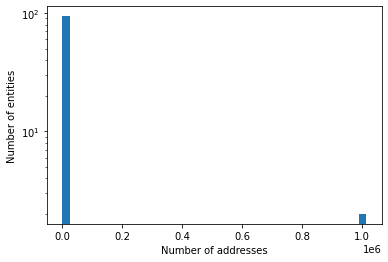

In [12]:
import matplotlib.pyplot as plt

#no_addresses_in_entities = [e for e in entities]
#no_addresses_in_entities

no_entity_addresses = [entity['no_addresses'] for entity in entities.values()]
plt.hist(no_entity_addresses, bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of addresses')
plt.yscale('log')
plt.show()

We can assume that entities with very large number of addresses are services (e.g., exchanges) or super-clusters. Therefore, for our further analysis, we filter our entities by **ignoring entities with more than 10K address**.

In [13]:
filtered_entities = [entity for entity in entities.values() if entity['no_addresses'] < 10000]

n_addresses = 0
usd_in = 0
for entity in filtered_entities:
    n_addresses += entity['no_addresses']
    for fv in entities[v]['total_received']['fiat_values']:
        if fv['code'] == 'usd':
            usd_in += fv['value']
    
print("{} entities with {:,.0f} addresses received {:,.0f} USD"
      .format(len(filtered_entities), n_addresses, usd_in))

94 entities with 562 addresses received 203,643 USD


# Q4: Where did the money come from, where did it go to?

For all filtered entities we now gather all incoming and outgoing entities.

In [ ]:
entity_nbrs_in = dict()
entity_nbrs_out = dict()

with graphsense.ApiClient(configuration) as api_client:
    api_instance = entities_api.EntitiesApi(api_client)
    for i, e in enumerate(filtered_entities):
        print(i+1, end='\r')
        if e['entity'] not in entity_nbrs_in:
            entity_nbrs_in[e['entity']] = api_instance.list_entity_neighbors(CURRENCY, int(e['entity']), 
                                                                          direction='in', include_labels=True)
        if e['entity'] not in entity_nbrs_out:
            entity_nbrs_out[e['entity']] = api_instance.list_entity_neighbors(CURRENCY, int(e['entity']),
                                                                           direction='out', include_labels=True)

To get an overview, we count the number of incoming and outgoing entities

In [ ]:
no_incoming_entities = {key:len(entity_nbrs_in[key]['neighbors']) for key in entity_nbrs_in}

no_outgoing_entities = {key:len(entity_nbrs_out[key]['neighbors']) for key in entity_nbrs_out}

In [ ]:
plt.hist(no_incoming_entities.values(), bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of incoming entities')
plt.yscale('log')
plt.show()

In [ ]:
plt.hist(no_outgoing_entities.values(), bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of incoming entities')
plt.yscale('log')
plt.show()

## Q5: Can we find any known entities (e.g., exchanges) in the digital money trace?

In [ ]:
# Collect IDs of those incoming entities that carry labels

known_incoming_entities = {}

for neighbors in entity_nbrs_in.values():
    for neighbor in neighbors['neighbors']:
        if len(neighbor['labels']) > 0:
            known_incoming_entities[neighbor['entity']['entity']] = neighbor['labels'][0]
            
pprint(known_incoming_entities)

In [ ]:
# Collect IDs of those outoging entities that carry labels

known_outgoing_entities = {}

for neighbors in entity_nbrs_out.values():
    for neighbor in neighbors['neighbors']:
        if len(neighbor['labels']) > 0:
            known_outgoing_entities[neighbor['entity']['entity']] = neighbor['labels'][0]
            
pprint(known_outgoing_entities)

## Network Visualization

Finally, we build and visualize a network showing the entities we just identified and collected.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

### Entities sending money to sextortion addresses

In [ ]:
g = nx.DiGraph()
for (entity, neighbors) in entity_nbrs_in.items():
    for neighbor in neighbors.neighbors:
        if len(neighbor.labels) > 0:
            g.add_edge(neighbor['entity']['entity'], entity)
            g.add_node(entity, label='sextortion')
            if neighbor['entity']['entity'] in known_incoming_entities:
                g.add_node(neighbor['entity']['entity'], label=known_incoming_entities[neighbor['entity']['entity']])
            else:
                g.add_node(neighbor['entity']['entity'], label='Unknown')                

In [ ]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

In [ ]:
node_colours = []

for node_id, values in list(g.nodes(data=True)):
    if(values['label'] == 'sextortion'):
        node_colours.append('red')
    else:
        node_colours.append('green')

In [ ]:
pos = nx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12, 8))
plt.title.text = "Known entities sending money to addresses involved in sextortion spam."
nx.draw(g, 
        edge_color='lightgrey',
        node_color=node_colours,
        node_size=12,
        pos=pos)


### Entities receiving money from sextortion addresses

In [ ]:
g = nx.DiGraph()
for (entity, neighbors) in entity_nbrs_out.items():
    for neighbor in neighbors.neighbors:
        if len(neighbor.labels) > 0:
            g.add_edge(neighbor['entity']['entity'], entity)
            g.add_node(entity, label='sextortion')
            if neighbor['entity']['entity'] in known_outgoing_entities:
                g.add_node(neighbor['entity']['entity'], label=known_outgoing_entities[neighbor['entity']['entity']])
            else:
                g.add_node(neighbor['entity']['entity'], label='Unknown')                

In [ ]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

In [ ]:
node_colours = []
label_dict = {}

for node_id, values in list(g.nodes(data=True)):
    if(values['label'] == 'sextortion'):
        node_colours.append('red')
    else:
        node_colours.append('green')
        label_dict[node_id] = node_id

In [ ]:
pos = nx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12, 8))
plt.title.text = "Known entities sending money to addresses involved in sextortion spam."
nx.draw(g, 
        edge_color='lightgrey',
        node_color=node_colours,
        node_size=12,
        labels=label_dict,
        with_labels=True,
        pos=pos)
